In [14]:
%load_ext autoreload
%autoreload 2

import os
device_count = 20
os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={device_count}"

from kinn_function import initialize_training, train, load_data, batched_state, encode_reactions, uncertainty_analysis
import jax.numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [84]:
pulse_train = [0, 1, 2, 5, 8]
pulse_test= [3, 4, 6, 7, 9]
data_train_multi, data_test_multi = load_data('../../data/TAP_thin_data.json',
          ['../../data/TAP_cat_in.json','../../data/TAP_cat_out.json'],
          exp_file='../../data/TAP_experimental_data.json', 
          pulse_train = pulse_train, pulse_test= pulse_test
          )

In [3]:
err_tags = ['Data','Model']
num_epochs = 1000
num_iter = 10
rxn = ['CO + * <-> CO*',
       'O2 + 2* -> 2O*',
       'CO* + O* <-> CO2 + 2*',
       'CO + O* -> CO2 + *']
species = ['CO','O2','CO2','CO*','O*','*']
encoded_rxn = encode_reactions(rxn,species)
weighted_param = 1e-10
n_gas = sum(1 for s in species if '*' not in s)


layer_sizes = [1+n_gas, 10, 10, 6]
model_size = [6]
params, opt_inv = initialize_training(layer_sizes, model_size)

In [4]:
# The loop below is set up to mimic the manual changing of the weighted_param value, but please note
# it cannot fully replicate the manual fine-tuning process. It is just a sample demonstration of how
# the weighted_param value can be changed during training.
# If you have any question about the detail tunning of weighted parameter, please contact dnai3@gatech.edu

for j in range(9):
       cycle = 5 - j//2
       for i in range(cycle):
              params = train(params,data_train_multi,num_epochs,num_iter,opt_inv,err_tags,
                             encoded_rxn,device_count,weighted_param)    
              [params, opt_inv] = params
              nn_params_inv, model_params_inv = params
              nn_params = nn_params_inv
              model_params = model_params_inv
       weighted_param *= 4

standard_deviation = uncertainty_analysis(params, data_train_multi, weighted_param/4, encoded_rxn) # devide 4 for the final multiplication

6.5536e-06
Epoch:  999, Loss Batch: 1.22693e-04, Fit Data: 2.66123e-02, Fit Model: 7.15423e-02
[Array([-11.44653708,  -0.49459012,  -0.25141234,   0.3086151 ,
        -0.01520764,  12.19689363], dtype=float64)]


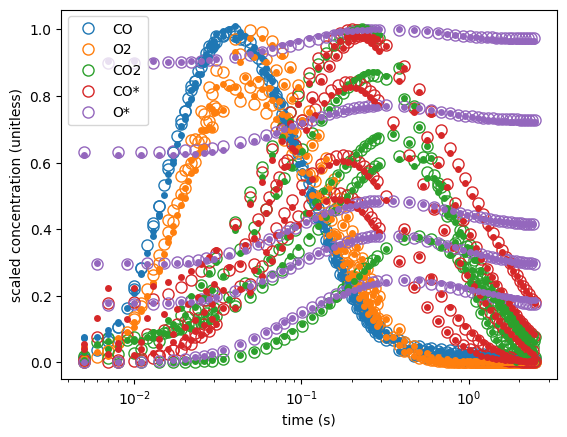

In [31]:
fig, axs = plt.subplots()
axs.plot(np.exp(data_train_multi[0][1][::3,0]), data_train_multi[0][0][::3,0:5], 'o', markerfacecolor='None', ms = 8)
axs.legend(['CO', 'O2', 'CO2', 'CO*', 'O*'])
axs.set_prop_cycle(None)
axs.plot(np.exp(data_train_multi[0][1][::3,0]),batched_state(nn_params_inv, data_train_multi[0][1])[::3,0:5],'o',
                      ms=5,markeredgecolor='none')
axs.set_xscale('log')
axs.set_xlabel('time (s)')
axs.set_ylabel('scaled concentration (unitless)');

/var/tmp/pbs.2418710.sawtoothpbs/ipykernel_11010/253400455.py:29: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  leg = fig.legend(['_nolegend_', '_nolegend_', '_nolegend_', '$CO$', '$O_2$', '$CO_2$'], ncol = 3, bbox_to_anchor=(0.7, 0.03), frameon = True);


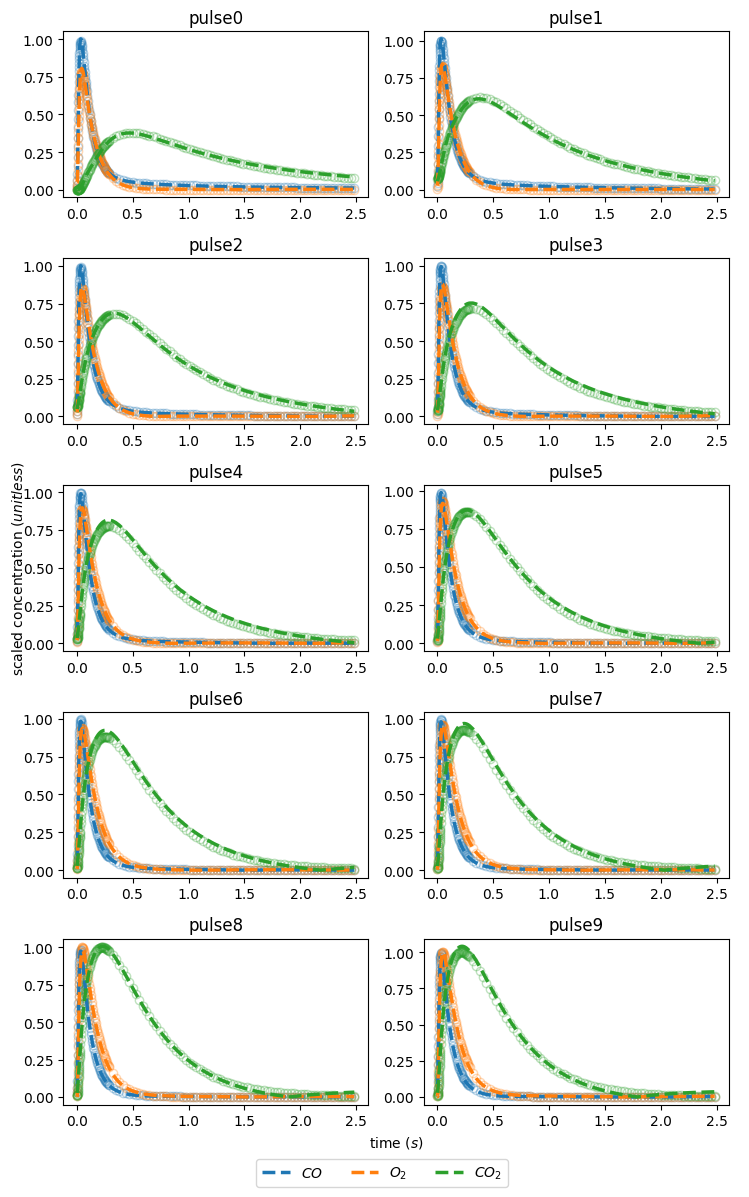

In [70]:
# The code below shows how we generate the figure in the paper. Change the index for adspecies figure.
# If you have any question about the figure generation, please contact dnai3@gatech.edu

fig, axs = plt.subplots(5,2, figsize=(8, 12), tight_layout = True)

fig.add_subplot(111, frameon=False)
plt.grid(False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('time $(s)$')
plt.ylabel('scaled concentration $(unitless)$')

n_p = int(len(data_train_multi[0][1])/len(pulse_train))

for n in range(10):
    if n in pulse_train:
        idx = pulse_train.index(n)
        axs[n//2, n%2].plot(np.exp(data_train_multi[0][1][n_p*idx:n_p*(idx+1),0]), data_train_multi[0][0][n_p*idx:n_p*(idx+1),:n_gas],'o',
                      alpha = 0.3, ms = 6, markerfacecolor = "None")
        axs[n//2, n%2].set_prop_cycle(None)
        axs[n//2, n%2].plot(np.exp(data_train_multi[0][1][n_p*idx:n_p*(idx+1),0]),
                             batched_state(nn_params, data_train_multi[0][1])[n_p*idx:n_p*(idx+1),:n_gas],'--',linewidth = 2.5)
        axs[n//2, n%2].set_title('pulse' + str(n))
    if n in pulse_test:
        idx = pulse_test.index(n)
        axs[n//2, n%2].plot(np.exp(data_test_multi[0][1][n_p*idx:n_p*(idx+1),0]), data_test_multi[0][0][n_p*idx:n_p*(idx+1),:n_gas],'o',
                      alpha = 0.3, ms = 6, markerfacecolor = "None")
        axs[n//2, n%2].set_prop_cycle(None)
        axs[n//2, n%2].plot(np.exp(data_test_multi[0][1][n_p*idx:n_p*(idx+1),0]),
                             batched_state(nn_params, data_test_multi[0][1])[n_p*idx:n_p*(idx+1),:n_gas],'--',linewidth = 2.5)
        axs[n//2, n%2].set_title('pulse' + str(n))

leg = fig.legend(['_nolegend_', '_nolegend_', '_nolegend_', '$CO$', '$O_2$', '$CO_2$'], ncol = 3, bbox_to_anchor=(0.7, 0.03), frameon = True);